## Imports 

In [278]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats
import pandas_profiling
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
#from sklearn.model_selection import KFold, StratifiedKFold
from imblearn.over_sampling import SMOTE

Reading data in

In [279]:
df = pd.read_csv('../data/loan.csv')

Selecting only the relevant columns

In [280]:
df = df[['loan_amnt', 'funded_amnt','term','int_rate','grade',
        'annual_inc', 'issue_d', 'dti', 'revol_bal','total_pymnt','loan_status']]

In [281]:
df_raw = df.copy()
#df = df_raw

## Data inspection

Quick look at the data

In [282]:
df.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
0,5000.0,5000.0,36 months,10.65,B,24000.0,Dec-2011,27.65,13648.0,5861.071414,Fully Paid
1,2500.0,2500.0,60 months,15.27,C,30000.0,Dec-2011,1.00,1687.0,1008.710000,Charged Off
2,2400.0,2400.0,36 months,15.96,C,12252.0,Dec-2011,8.72,2956.0,3003.653644,Fully Paid
3,10000.0,10000.0,36 months,13.49,C,49200.0,Dec-2011,20.00,5598.0,12226.302212,Fully Paid
4,3000.0,3000.0,60 months,12.69,B,80000.0,Dec-2011,17.94,27783.0,3242.170000,Current


There are 887k loans in total

In [283]:
df.shape

(887379, 11)

Running pandas profiler tool

In [284]:
#pandas_profiling.ProfileReport(df)

## Data cleaning

### Format transformation 

Removing all the trailing whitespaces

In [285]:
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

Creating year and month columns for dates to analyze distribution over years

In [286]:
df['issue_month'], df['issue_year'] = df['issue_d'].str.split('-', 1).str
df['issue_d'] = df['issue_d'].astype('datetime64[ns]')

### Missing values treatment 

Only annual_inc has missing values (4)

In [287]:
df.isnull().sum().sort_values(ascending=False).head()

annual_inc     4
issue_year     0
issue_month    0
loan_status    0
total_pymnt    0
dtype: int64

#### Interpolation of values

We're filling in missing values for annual income - only variable with misssing value. Since the annual income is highly correlated with funded amount, interpoloation was used as a method to fill in NAs.

In [288]:
df['annual_inc'] = df[['annual_inc', 'funded_amnt']].interpolate(method='values')[['annual_inc']]

In [468]:
df_clean = df.copy()
#df = df_clean

There are no more missing values

In [469]:
df.isnull().sum().sort_values(ascending=False).head()

issue_year     0
issue_month    0
loan_status    0
total_pymnt    0
revol_bal      0
dtype: int64

## Data selection

We select only loans with 36 months term

In [470]:
df = df.loc[df.term == '36 months']

Term variable is now redundant

In [471]:
df.drop(['term'],axis=1,inplace=True)

Last loan is from Dec 2015

In [472]:
print(max(df.issue_d))

2015-12-01 00:00:00


We select only loans which were issued at least 36 months ago (until Dec 2012)

In [473]:
df.issue_year = df.issue_year.astype(int)
df = df.loc[df.issue_year < 2013]

There are 75k loans with term of 36 months that were issued until Dec 2012

In [474]:
df.shape

(75004, 12)

In [476]:
df_subset = df.copy()
#df = df_subset

## Target variable definition 

As per Part 2, assuming that all non-fully paid loans are defaulted

In [477]:
df['default'] = 1
df.loc[df['loan_status'].isin(['Fully Paid'])
       , 'default'] = 0
df['default'].value_counts()

0    63357
1    11647
Name: default, dtype: int64

Default rate of 15.5% (Note that it's sligthly different than answer in Part 2 as loans not meeting credit policy were excluded there)

In [478]:
df.default.mean()

0.15528505146392194

Loan status variable is now redundant

In [479]:
df.drop(['loan_status'],axis=1,inplace=True)

## Feature transformation

### Annual income

In [480]:
df.annual_inc.describe()

count    7.500400e+04
mean     6.726449e+04
std      6.194995e+04
min      1.896000e+03
25%      4.000000e+04
50%      5.700000e+04
75%      8.000000e+04
max      7.141778e+06
Name: annual_inc, dtype: float64

Income is highly skewed, with very few, very high values, and most of the borrowers below \$100,000

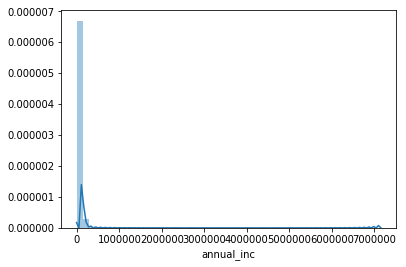

In [481]:
sns.distplot(df.annual_inc)

We transform the income to log(income) to reduce the skewness

In [482]:
df['log_annual_inc'] = np.log(df.annual_inc)

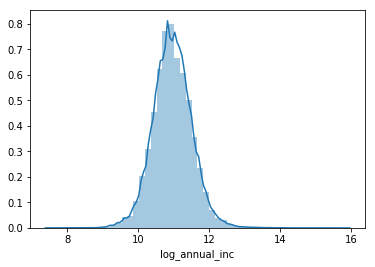

In [483]:
sns.distplot(df.log_annual_inc)

Loans that were paid were taken by borrowers with higher income

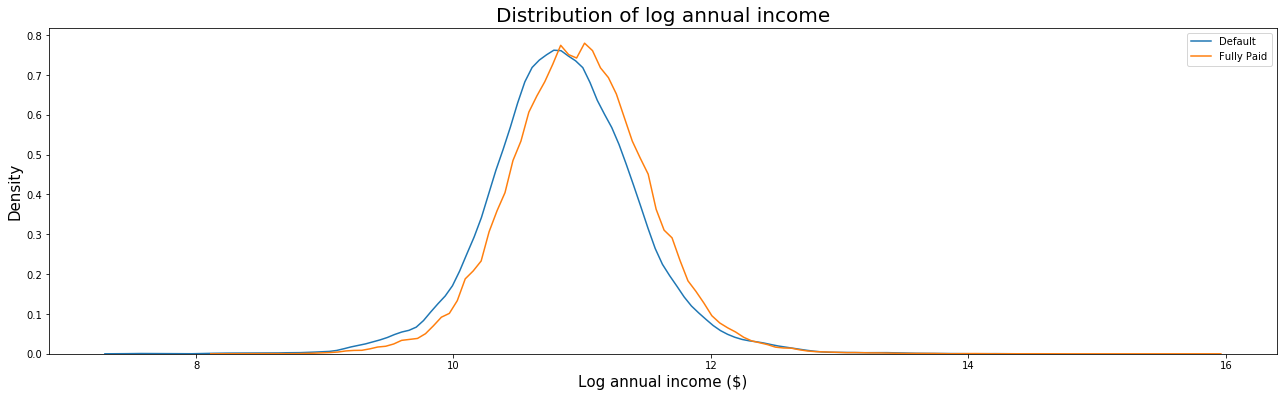

In [484]:
fig = plt.figure(figsize=(22,6))
sns.kdeplot(df.loc[df['default'] == 1, 'log_annual_inc'], label = 'Default')
sns.kdeplot(df.loc[df['default'] == 0, 'log_annual_inc'], label = 'Fully Paid')
plt.xlabel('Log annual income ($)',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.title('Distribution of log annual income',fontsize=20);

We also create categorical variables by binning the original variable

In [485]:
labels = ['0-20k', '20-40k', '40-60k', '60-80k', '80k+']
df['annual_inc_group'] = pd.cut(df.annual_inc, 
                               [0, 20000, 40000, 60000, 80000, 10000000], right=False, labels=labels)
df['annual_inc_group'].value_counts()

40-60k    21683
80k+      19953
60-80k    15978
20-40k    15595
0-20k      1795
Name: annual_inc_group, dtype: int64

### Revolving balance

In [486]:
df.revol_bal.describe()

count    7.500400e+04
mean     1.402502e+04
std      1.853212e+04
min      0.000000e+00
25%      5.028000e+03
50%      9.982500e+03
75%      1.742400e+04
max      1.207359e+06
Name: revol_bal, dtype: float64

Revolving balance is highly skewed, with very few, very high values, and most of the borrowers below \$10,000

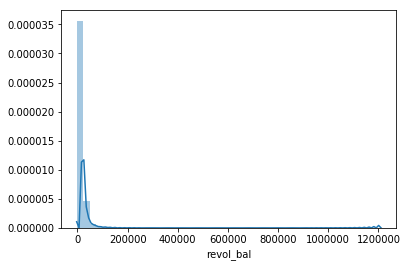

In [487]:
sns.distplot(df.revol_bal)

We transform the revolving balanace to log(revolving balance) to reduce the skewness. Some borrowes have zero revolving balance so we shift the distribution by 1

In [488]:
df['log_revol_bal'] = np.log(df.revol_bal+1)
#df['no_revol_bal'] = 0
#df.loc[df['revol_bal'] == 0, 'no_revol_bal'] = 1

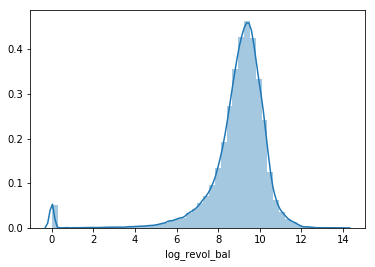

In [489]:
sns.distplot(df.log_revol_bal)

Loans that were paid were taken by borrowers with higher revolving balance

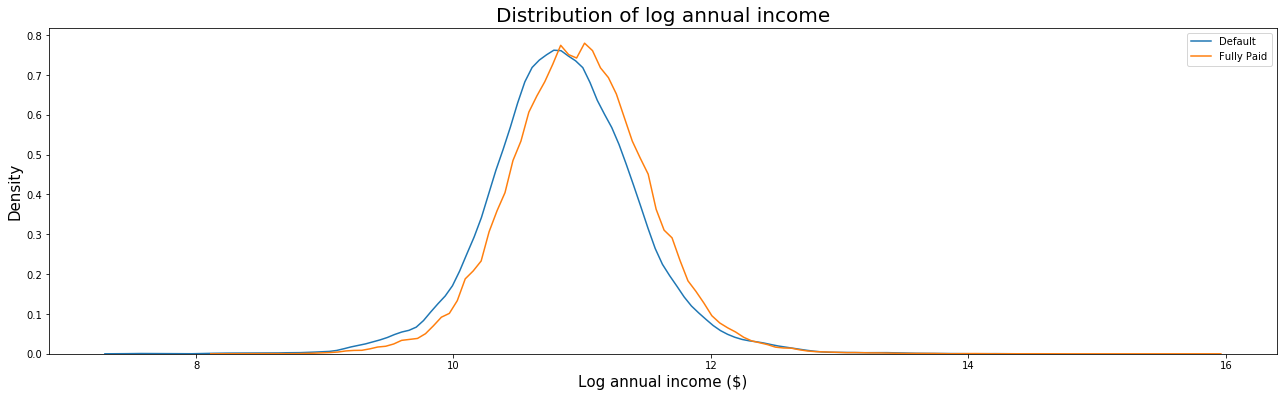

In [490]:
fig = plt.figure(figsize=(22,6))
sns.kdeplot(df.loc[df['default'] == 1, 'log_annual_inc'], label = 'Default')
sns.kdeplot(df.loc[df['default'] == 0, 'log_annual_inc'], label = 'Fully Paid')
plt.xlabel('Log annual income ($)',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.title('Distribution of log annual income',fontsize=20);

We also create categorical variables by binning the original variable

In [491]:
labels = ['0', '0-5k', '5-10k', '10-15k', '15-20k', '20k+']
df['revol_bal_group'] = pd.cut(df.revol_bal, 
                               [0, 1, 5000, 10000, 15000, 20000, 10000000], right=False, labels=labels)
df['revol_bal_group'].value_counts()

5-10k     18918
0-5k      17551
20k+      14914
10-15k    14022
15-20k     8506
0          1093
Name: revol_bal_group, dtype: int64

### Loan amount 

Most loans are within \$5,000 and \$15,000

In [492]:
df.loan_amnt.describe()

count    75004.000000
mean     10778.257826
std       6851.673213
min        500.000000
25%       6000.000000
50%       9950.000000
75%      14400.000000
max      35000.000000
Name: loan_amnt, dtype: float64

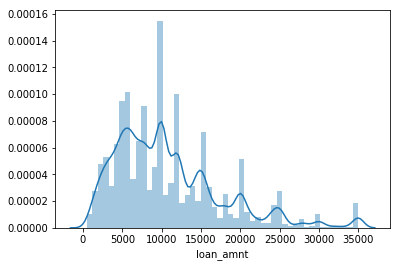

In [493]:
sns.distplot(df.loan_amnt)

Loans that were paid were taken for slightly higher amounts

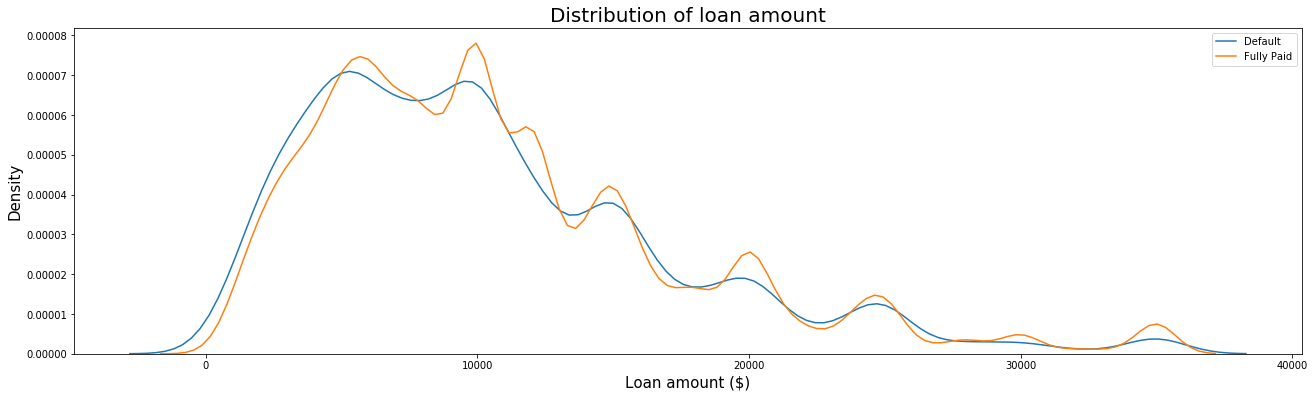

In [494]:
fig = plt.figure(figsize=(22,6))
sns.kdeplot(df.loc[df['default'] == 1, 'loan_amnt'], label = 'Default')
sns.kdeplot(df.loc[df['default'] == 0, 'loan_amnt'], label = 'Fully Paid')
plt.xlabel('Loan amount ($)',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.title('Distribution of loan amount',fontsize=20);

We also create categorical variables by binning the original variable

In [495]:
labels = ['0-5k', '5-10k', '10-15k', '15-20k', '20k+']
df['loan_amnt_group'] = pd.cut(df.loan_amnt, 
                               [0, 5000, 10000, 15000, 20000, 100000], right=False, labels=labels)
df['loan_amnt_group'].value_counts()

5-10k     24407
10-15k    19479
0-5k      13165
20k+       9218
15-20k     8735
Name: loan_amnt_group, dtype: int64

### Interest rate

Most loans have interest rate between 7% and 15%

In [496]:
df.int_rate.describe()

count    75004.000000
mean        12.037718
std          3.648870
min          5.420000
25%          8.900000
50%         12.120000
75%         14.330000
max         24.890000
Name: int_rate, dtype: float64

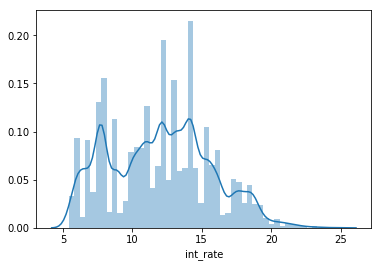

In [497]:
sns.distplot(df.int_rate)

Loans that defaulted had higher interest rate. The interest burden made the repayment more difficult and loans with higher interest rates were likely to be considered more risky.

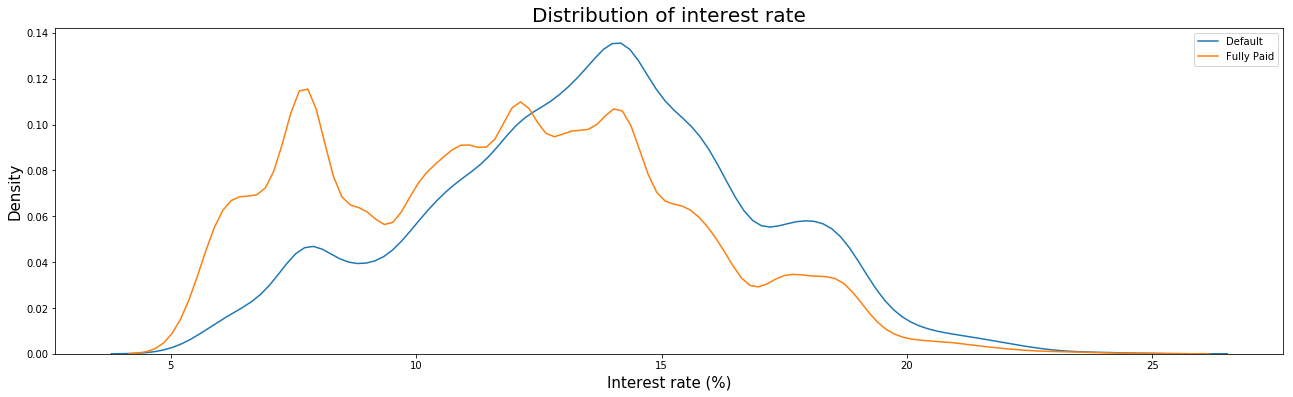

In [498]:
fig = plt.figure(figsize=(22,6))
sns.kdeplot(df.loc[df['default'] == 1, 'int_rate'], label = 'Default')
sns.kdeplot(df.loc[df['default'] == 0, 'int_rate'], label = 'Fully Paid')
plt.xlabel('Interest rate (%)',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.title('Distribution of interest rate',fontsize=20);

We also create categorical variables by binning the original variable

In [499]:
labels = ['5-8', '8-11', '11-13', '13-15', '20+']
df['int_rate_group'] = pd.cut(df.int_rate, 
                               [5, 8, 11, 13, 15, 100], right=False, labels=labels)
df['int_rate_group'].value_counts()

13-15    16026
5-8      15926
20+      15914
11-13    13794
8-11     13344
Name: int_rate_group, dtype: int64

### DTI

Most loans have DTI between 5% and 25%

In [500]:
df.dti.describe()

count    75004.000000
mean        15.013122
std          7.447380
min          0.000000
25%          9.380000
50%         14.850000
75%         20.392500
max         34.990000
Name: dti, dtype: float64

Distribution of DTI looks fairly normal

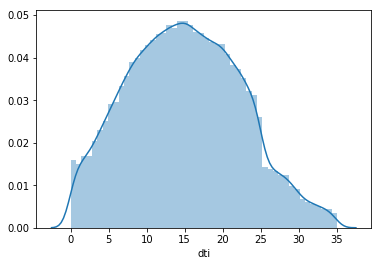

In [501]:
sns.distplot(df.dti)

Loans that defaulted had higher DTI. The higher share of interest made the repayment more difficult.

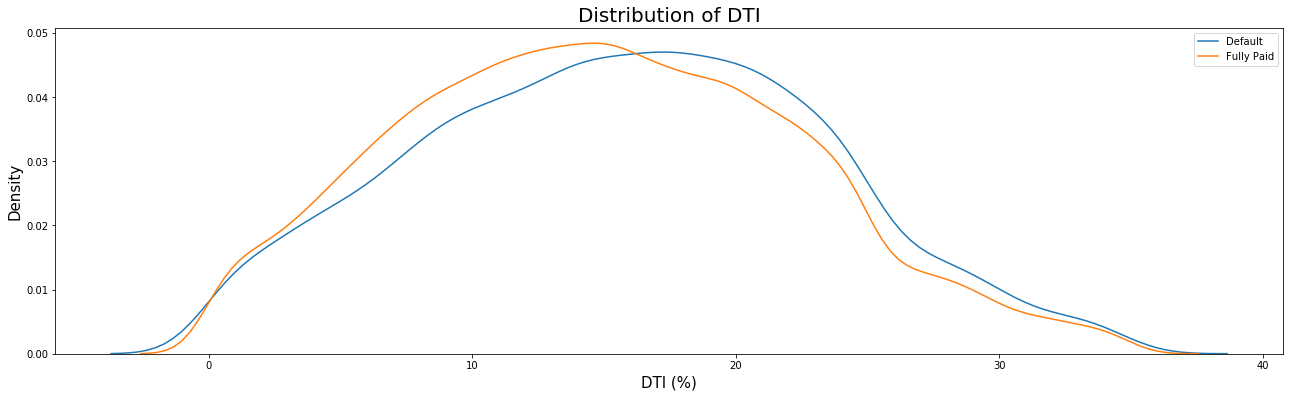

In [502]:
fig = plt.figure(figsize=(22,6))
sns.kdeplot(df.loc[df['default'] == 1, 'dti'], label = 'Default')
sns.kdeplot(df.loc[df['default'] == 0, 'dti'], label = 'Fully Paid')
plt.xlabel('DTI (%)',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.title('Distribution of DTI',fontsize=20);

We also create categorical variables by binning the original variable

In [503]:
labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25+']
df['dti_group'] = pd.cut(df.dti, 
                               [0, 5, 10, 15, 20, 25, 100], right=False, labels=labels)
df['dti_group'].value_counts()

10-15    17366
15-20    16973
5-10     13464
20-25    13385
0-5       7197
25+       6619
Name: dti_group, dtype: int64

### Categorical variables encoding

Grade and issue_month have more than 2 possible values. They will need to be one-hot encoded before we can use them in the modeling

In [504]:
df.select_dtypes(['category', 'object']).apply(pd.Series.nunique, axis = 0)

grade                7
issue_month         12
annual_inc_group     5
revol_bal_group      6
loan_amnt_group      5
int_rate_group       5
dti_group            6
dtype: int64

We create dummy variables for grade and issue month

In [505]:
df = pd.get_dummies(df)

In [506]:
df_dummies = df.copy()
#df = df_dummies

## Feature selection 

Dropping variables which are not known at the time of application:
- funded_amnt: the total amount committed to that loan at that point in time is not known at the time of application
- total_pymnt: payments received to date for total amount funded are only known after issuing the loan

In [507]:
df.drop(['total_pymnt', 'funded_amnt'],axis=1,inplace=True)

Dropping variables which cannot be observed historically
- issue_d: we cannot predict the time impact for future observations (years). We can however use monthly seasonality effects
- int_rate: it is not completely clear if interest rate can be observed at the time of origination (assuming yes). It will have impact on borrowers ability to repay but it is also an outcome of the credit decision and may only be know if the investors have shown interest
- grade: similar to interest rate, it's not fully clear if grade is available upon origination (assuming yes)

In [508]:
df.drop(['issue_d', 'issue_year'],axis=1,inplace=True)

Dropping extra dummy variables

In [509]:
df.drop(['loan_amnt_group_0-5k', 'int_rate_group_5-8', 'grade_A', 
         'annual_inc_group_0-20k', 'dti_group_0-5', 
         'revol_bal_group_0', 'issue_month_Jan'],axis=1,inplace=True)

In [510]:
corr = df.corr()['default'].sort_values()
corr

log_annual_inc            -0.079541
annual_inc_group_80k+     -0.055434
grade_B                   -0.050091
int_rate_group_8-11       -0.044964
annual_inc                -0.039977
dti_group_5-10            -0.024916
annual_inc_group_60-80k   -0.023839
loan_amnt                 -0.023385
log_revol_bal             -0.023043
loan_amnt_group_10-15k    -0.018957
dti_group_10-15           -0.018561
loan_amnt_group_20k+      -0.013838
revol_bal_group_10-15k    -0.012313
issue_month_Sep           -0.008896
issue_month_Aug           -0.007836
issue_month_Nov           -0.007189
revol_bal_group_15-20k    -0.006949
issue_month_Dec           -0.005076
issue_month_Oct           -0.004797
revol_bal_group_20k+      -0.002299
int_rate_group_11-13      -0.000570
revol_bal_group_5-10k      0.000112
issue_month_May            0.000567
issue_month_Jul            0.001503
loan_amnt_group_5-10k      0.001961
issue_month_Apr            0.002659
issue_month_Jun            0.004651
dti_group_15-20            0

In [511]:
df_features = df
#df = df_features

## Train-test split 

Splitting the data into train and test sets (80/20 proportion)

In [512]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('default',axis=1),df['default'],test_size=0.2,random_state=17)

In [513]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60003, 46) (15001, 46) (60003,) (15001,)


Standardizing the numerical features

In [514]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test=sc.transform(X_test)

Oversampling the training set using SMOTE. Default rate in training set at 50%, in the test set kept at 15%

In [515]:
sm = SMOTE(random_state=17, ratio = 1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [516]:
print(df.default.mean(), y_train.mean(), y_test.mean())

0.15528505146392194 0.5 0.15392307179521364


## Logistic regression model

### Model training

In [517]:
log_reg = LogisticRegression(C = 1,random_state=17)
log_reg.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=17, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [518]:
y_pred = log_reg.predict_proba(X_test)[:, 1]

#### Coefficient estimates

In [519]:
feature_cols = df.drop('default',axis=1).columns.values
list(zip(feature_cols, log_reg.coef_[0]))

[('loan_amnt', -0.016562694080661557),
 ('int_rate', -0.4358108392038945),
 ('annual_inc', 0.009123365293456573),
 ('dti', 0.1012744370734465),
 ('revol_bal', 0.31842806547907887),
 ('log_annual_inc', -0.32876271797330275),
 ('log_revol_bal', -0.13867976911740104),
 ('grade_B', 0.24557681020212083),
 ('grade_C', 0.5002928860435619),
 ('grade_D', 0.5863051240842234),
 ('grade_E', 0.41976794015473184),
 ('grade_F', 0.2618412205618547),
 ('grade_G', 0.24703649391964363),
 ('issue_month_Apr', -0.07129339771121104),
 ('issue_month_Aug', -0.09186775418758393),
 ('issue_month_Dec', -0.07697853870218084),
 ('issue_month_Feb', -0.05181779013443937),
 ('issue_month_Jul', -0.07047520289498357),
 ('issue_month_Jun', -0.04788397863637835),
 ('issue_month_Mar', -0.06607377863787431),
 ('issue_month_May', -0.042191294294194916),
 ('issue_month_Nov', -0.09301470900649711),
 ('issue_month_Oct', -0.08665698051887055),
 ('issue_month_Sep', -0.08722515093377906),
 ('annual_inc_group_20-40k', 0.11946155830

###  Model performance

#### Accuracy score

In [520]:
print(accuracy_score(y_test, log_reg.predict(X_test)))

0.6318912072528499


#### AUC 

In [521]:
auc = roc_auc_score(y_test, y_pred)
print(auc)

0.682362463875786


AUC score of 68% is relatively low but better than random (50%)

#### ROC curve

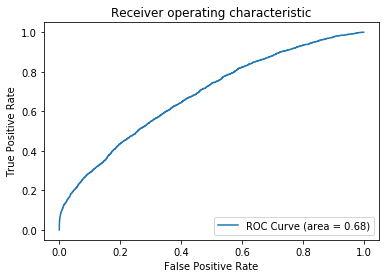

In [522]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % auc)
plt.title('Receiver operating characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

Model achieves similar performance across thresholds

#### Classification report

In [523]:
print(classification_report(y_test, log_reg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.64      0.75     12692
           1       0.23      0.61      0.34      2309

   micro avg       0.63      0.63      0.63     15001
   macro avg       0.57      0.62      0.54     15001
weighted avg       0.80      0.63      0.68     15001



Model has relatively low precision for defaults - only 23% loans identified as too risky turn out to be good. However the interest from a good loan (5-25%) is signigicantly lower than loss from a bad loan (up to 100%)



#### Confusion matrix

In [524]:
print(confusion_matrix(y_test, log_reg.predict(X_test)))

[[8069 4623]
 [ 899 1410]]


#### Coefficient estimates

In [462]:
feature_cols = df.drop('default',axis=1).columns.values
list(zip(feature_cols, log_reg.coef_[0]))

[('loan_amnt', -0.01656272055266706),
 ('int_rate', -0.4358107133831933),
 ('annual_inc', 0.009123300480228132),
 ('dti', 0.10127465660371436),
 ('revol_bal', 0.3184280709615705),
 ('log_annual_inc', -0.32876285652260767),
 ('log_revol_bal', -0.13867969812031927),
 ('grade_B', 0.24557676069450263),
 ('grade_C', 0.5002929690088491),
 ('grade_D', 0.5863051934604866),
 ('grade_E', 0.4197679408450527),
 ('grade_F', 0.2618412260384649),
 ('grade_G', 0.2470364970701453),
 ('issue_month_Apr', -0.0712934182559858),
 ('issue_month_Aug', -0.09186774012757805),
 ('issue_month_Dec', -0.07697853306813604),
 ('issue_month_Feb', -0.05181781271066147),
 ('issue_month_Jul', -0.07047518873440144),
 ('issue_month_Jun', -0.04788398294683956),
 ('issue_month_Mar', -0.06607380411378455),
 ('issue_month_May', -0.04219131816282244),
 ('issue_month_Nov', -0.09301469080520924),
 ('issue_month_Oct', -0.08665696314414205),
 ('issue_month_Sep', -0.08722512790502121),
 ('annual_inc_group_20-40k', 0.1194616441913659

In [528]:
df.groupby('default').mean()['int_rate']

default
0    11.767331
1    13.508565
Name: int_rate, dtype: float64

We would invest only in the loans that were predicted as 0 by the model (non-default). The model predict that 8069+899 loans are not risky, and gets 899 of them wrong (90% precision rate for zeroes). This means that in order to make money, we would have to lose on a loan at most 9x more of what we earn on the loans where we don't loose.

In fact, we get 12% interest on an average good loan. Even if we loose all the money from the non-performing loans (which is very unlikely), we would expect to earn interst of 0.9*12% + 0.1*(-100%) > 0 

### 1) What percentage of loans has been fully paid?

In [452]:
by_loan_status = df_subset.groupby('loan_status').size().sort_values(ascending=False)
print(by_loan_status)

loan_status
Fully Paid                                             63357
Charged Off                                             9071
Does not meet the credit policy. Status:Fully Paid      1789
Does not meet the credit policy. Status:Charged Off      649
Late (31-120 days)                                        81
Current                                                   33
Default                                                   12
Late (16-30 days)                                          6
In Grace Period                                            6
dtype: int64


Most of the loans are either fully paid or charged off after 36 months. Some loans (3% of all) are not currently meeting the credit policy. Only small proportion of loands (<0.2%) have one of other statuses.

There are two types of loans that are marked as fully paid:
- Fully paid
- Does not meet the credit policy. Status:Fully Paid

We will calculate the percentage for all fully paid and only the ones meeting credit policy

In [453]:
all_fully_paid = sum(by_loan_status.loc[['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']])
fully_paid_within_policy = by_loan_status.loc['Fully Paid']
all_loans = len(df)
loans_within_policy = len(df) - sum(by_loan_status.loc[[
    'Does not meet the credit policy. Status:Charged Off', 'Does not meet the credit policy. Status:Fully Paid']])
print('Fully paid loans (incl. not meeting credit policy) as % of all loans:', all_fully_paid / all_loans)
print('Fully paid loans as % of all loans:', fully_paid_within_policy / all_loans)
print('Fully paid loans (incl. not meeting credit policy) as % of loans that meet credit policy:', fully_paid_within_policy / loans_within_policy)

Fully paid loans (incl. not meeting credit policy) as % of all loans: 0.8685670097594795
Fully paid loans as % of all loans: 0.8447149485360781
Fully paid loans (incl. not meeting credit policy) as % of loans that meet credit policy: 0.8730948378028278


#### ANSWER: Fully paid loans represent ~84-87% of all loans, depending on how we define it

### 2) When bucketed by year of origination and grade, which cohort has the highest rate of defaults? Here you may assume that any loan which was not fully paid had “defaulted”.

Assuming that all non-fully paid loans are defaulted

In [455]:
df_subset['default'] = 1
df_subset.loc[df_subset['loan_status'] == 'Fully Paid', 'default'] = 0
by_default = df_subset.groupby('default').size().sort_values(ascending=False)
print(by_default)

default
0    63357
1    11647
dtype: int64


First we look at the number of loans for each of the cohorts. More recent loands are more common (growing business) and high grades (E-G) are fairly rare.

In [456]:
df_subset.groupby(['issue_year', 'grade']).count()[['default']].unstack(1).fillna(0)

default                                 
grade            A      B     C     D    E    F   G
issue_year                                         
2007            78     98   141    99  100   52  35
2008           318    594   580   419  285  111  86
2009          1203   1445  1348   817  308  105  55
2010          2567   2805  2070  1253  336   91  34
2011          5579   4722  2203  1261  272   54  10
2012         10753  16805  9902  5088  795  103  24

Defaults rates for loans issued in 2007 (66%) and 2008 (45%) are much higher than for more current years (11-22%). This may be related to the financial crisis that negatively affected financial condition of lenders

In [457]:
df_subset.groupby(['issue_year']).mean()[['default']].T

issue_year,2007,2008,2009,2010,2011,2012
default,0.658375,0.450481,0.219466,0.167322,0.106305,0.137612


Default rates are more common for higher grades of loans, across all loand issue year. This suggests that the LC policy reflects quite well the riskiness of loans. The exception are loans from 2012 where grades F and G had lower default rates than grades D and E, however number of loans for grades F and G is relatively low.

In [458]:
df_subset.groupby(['grade']).mean()[['default']].T

grade,A,B,C,D,E,F,G
default,0.070446,0.130719,0.197119,0.256014,0.375477,0.536822,0.77459


In [459]:
df_subset.groupby(['issue_year', 'grade']).mean()[['default']].unstack(1).fillna(0)

default                                                    \
grade              A         B         C         D         E         F   
issue_year                                                               
2007        0.282051  0.459184  0.567376  0.777778  0.910000  0.903846   
2008        0.125786  0.271044  0.379310  0.599045  0.778947  0.900901   
2009        0.086451  0.163322  0.245549  0.334149  0.399351  0.495238   
2010        0.053370  0.134403  0.224155  0.294493  0.348214  0.505495   
2011        0.063990  0.105676  0.155243  0.180809  0.205882  0.240741   
2012        0.072910  0.127462  0.178247  0.214230  0.223899  0.184466   

                      
grade              G  
issue_year            
2007        1.000000  
2008        0.976744  
2009        0.727273  
2010        0.647059  
2011        0.400000  
2012        0.166667

### 3) When bucketed by year of origination and grade, what annualized rate of return have these loans generated on average? For simplicity, use the following approximation:

Annualized rate of return = (total_pymnt / funded_amnt) ^ (1/3) - 1

Unweighted average ARR amounted to 1.9% per loan

In [460]:
df_subset['arr'] = (df_subset.total_pymnt / df_subset.funded_amnt) ** (1/3) - 1
df_subset.arr.mean()

0.019088078445375235

Total ARR amounted to 3% for all loans (whole portfolio) weighted by loan amounts

In [461]:
(sum(df_subset.total_pymnt) / sum(df_subset.funded_amnt)) ** (1/3) - 1

0.030675197335574556